In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('D:\\Career\\GradProj\\New deal\\Dataset\\parkinson_data.csv')
df.drop('Unnamed: 0', axis = 1,inplace=True)

df.columns = ['Time',
 'AccV',
 'AccML',
 'AccAP',
 'StartHesitation',
 'Turn',
 'Walking',
 'idx',
 'ID',
 'len_df']

In [3]:
df['class'] = np.array(df['Walking'] | df['StartHesitation'] | df['Turn'],dtype = int)
df[['normal','fog']] = pd.get_dummies(df['class'], prefix='class')


# Compute the mean and standard deviation of the dataset
data = np.asarray(df[['AccV','AccML','AccAP']] , dtype = np.float64)
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)

df[['AccV','AccML','AccAP']] = abs((data - mean) / std)

<AxesSubplot:>

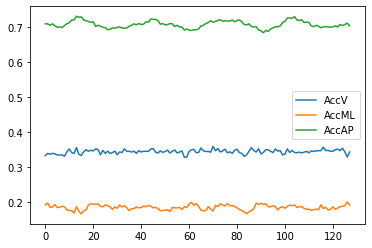

In [4]:
df[['AccV','AccML','AccAP']][0:128].plot()

In [5]:
x_win = []
y_win = []

x = df[['AccV']]#,'AccML','AccAP']]
y = df[['fog','normal']]

for i in range(0,len(df)-len(df)%256,128):
    x_win.append(x[i:i+256])
    y_win.append(y[i:i+256])
    
x_win.pop()
y_win.pop()
x_win = np.asarray(x_win,dtype = np.float32)
y_win = np.asarray(y_win,dtype = int)

In [6]:
from scipy import stats
y_win_s2l = []
for i in y_win:
    y_win_s2l.append(stats.mode(i)[0][0])
y_win_s2l = np.asarray(y_win_s2l,dtype = int)

In [7]:
x_win_aug = []
y_win_s2l_aug = []
for i in range(len(y_win_s2l)):
    x_win_aug.append(x_win[i])
    y_win_s2l_aug.append(y_win_s2l[i])
    
    if y_win_s2l[i,0]==1:
        x_win_aug.append(x_win[i])
        y_win_s2l_aug.append(y_win_s2l[i])
x_win_aug = np.asarray(x_win_aug,dtype = np.float32)
y_win_s2l_aug = np.asarray(y_win_s2l_aug,dtype = int)

In [8]:
# Importing Layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,BatchNormalization,Input,Bidirectional,Conv1D,MaxPooling1D,Flatten
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [9]:
# rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="accuracy",factor=0.5,patience=8,)
# earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=15)
# checkpointer = ModelCheckpoint_tweaked(filepath='best.hdf5', verbose=0, save_best_only=True)
# csv_logger = tf.keras.callbacks.CSVLogger("model_history_log.csv", append=True)

In [10]:
# x_train, x_test, y_train, y_test = train_test_split(x_win_aug, y_win_s2l_aug, test_size=0.10)
# x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50)

# model_aug = Sequential([
#     LSTM(100, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = False ),
#     Dropout(0.2),
#     Dense(2, activation = 'softmax') 
# ])

# model_aug.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),#, clipvalue=0.5),
#                 loss='categorical_crossentropy', 
#                 metrics=['accuracy'],
                
#                 )

# model_aug.summary()
# tf.config.list_physical_devices('GPU')

In [11]:
# model_aug.fit(x_train, y_train, batch_size = 256, epochs = 1000, callbacks = [rlr,earlystop,checkpointer,csv_logger],validation_data=(x_val,y_val))

In [12]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        print(' - lr:',model.optimizer._decayed_lr(tf.float32).numpy())

In [18]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=False)
models = []
evals = []
k = 0
rlr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.001,decay_steps=409,decay_rate=0.96,staircase=True)

In [19]:
for train, test in kfold.split(x_win_aug, y_win_s2l_aug):
    x_train, x_val, y_train, y_val = train_test_split(x_win_aug[train], y_win_s2l_aug[train], test_size=0.10)

    model = Sequential([
        LSTM(100, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,1), return_sequences = False ),
        Dropout(0.2),

        Dense(2, activation = 'softmax') 
    ])
    
    model.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = rlr),#, clipvalue=0.5),
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'],
                    )

    
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=25)
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f'best_{k}.hdf5', verbose=0, save_best_only=True,monitor='val_accuracy',mode='max')
    csv_logger = tf.keras.callbacks.CSVLogger(f"history_log_{k}.csv")

    model.fit(x_train, y_train, batch_size = 256, epochs = 500, callbacks = [earlystop,checkpointer,csv_logger,CustomCallback()],validation_data=(x_val,y_val))
    model = tf.keras.models.load_model(f'best_{k}.hdf5')
    models.append(model)
    evals.append(model.evaluate(x_win_aug[test],y_win_s2l_aug[test]))
    
    k+=1

Epoch 1/500
  6/204 [..............................] - ETA: 11s - loss: 0.7020 - accuracy: 0.5254WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0270s vs `on_train_batch_end` time: 0.0324s). Check your callbacks.


204/204 [==============================] - 14s 64ms/step - loss: 0.6945 - accuracy: 0.5497 - val_loss: 0.6900 - val_accuracy: 0.5783
Epoch 2/500
204/204 [==============================] - 13s 62ms/step - loss: 0.6811 - accuracy: 0.5761 - val_loss: 0.6793 - val_accuracy: 0.5918
Epoch 3/500
204/204 [==============================] - 13s 62ms/step - loss: 0.6577 - accuracy: 0.6289 - val_loss: 0.6664 - val_accuracy: 0.6143
Epoch 4/500
204/204 [==============================] - 13s 62ms/step - loss: 0.6668 - accuracy: 0.6131 - val_loss: 0.6646 - val_accuracy: 0.6224
Epoch 5/500
204/204 [==============================] - 13s 62ms/step - loss: 0.6456 - accuracy: 0.6239 - val_loss: 0.6353 - val_accuracy: 0.6389
Epoch 6/500
204/204 [==============================] - 13s 62ms/step - loss: 0.6268 - accuracy: 0.6523 - val_loss: 0.6276 - val_accuracy: 0.6572
Epoch 7/500
204/204 [==============================] - 13s 62ms/step - loss: 0.6206 - accuracy: 0.6572 - val_loss: 0.6228 - val_accuracy: 0.65

204/204 [==============================] - 15s 67ms/step - loss: 0.6994 - accuracy: 0.5270 - val_loss: 0.6914 - val_accuracy: 0.5418
Epoch 2/500
204/204 [==============================] - 13s 62ms/step - loss: 0.7023 - accuracy: 0.5408 - val_loss: 0.7056 - val_accuracy: 0.5105
Epoch 3/500
204/204 [==============================] - 12s 61ms/step - loss: 0.7011 - accuracy: 0.5188 - val_loss: 0.6992 - val_accuracy: 0.5110
Epoch 4/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6977 - accuracy: 0.5313 - val_loss: 0.6878 - val_accuracy: 0.5686
Epoch 5/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6992 - accuracy: 0.5280 - val_loss: 0.7002 - val_accuracy: 0.5015
Epoch 6/500
204/204 [==============================] - 12s 61ms/step - loss: 0.7001 - accuracy: 0.5158 - val_loss: 0.6989 - val_accuracy: 0.5201
Epoch 7/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6993 - accuracy: 0.5138 - val_loss: 0.6971 - val_accuracy: 0.52

204/204 [==============================] - 14s 62ms/step - loss: 0.6966 - accuracy: 0.5435 - val_loss: 0.6941 - val_accuracy: 0.5511
Epoch 2/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6858 - accuracy: 0.5635 - val_loss: 0.6967 - val_accuracy: 0.5302
Epoch 3/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6937 - accuracy: 0.5503 - val_loss: 0.7089 - val_accuracy: 0.5288
Epoch 4/500
204/204 [==============================] - 12s 61ms/step - loss: 0.7020 - accuracy: 0.5213 - val_loss: 0.6989 - val_accuracy: 0.5284
Epoch 5/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6992 - accuracy: 0.5270 - val_loss: 0.6981 - val_accuracy: 0.5284
Epoch 6/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6981 - accuracy: 0.5311 - val_loss: 0.6982 - val_accuracy: 0.5284
Epoch 7/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6968 - accuracy: 0.5295 - val_loss: 0.6948 - val_accuracy: 0.52

204/204 [==============================] - 14s 63ms/step - loss: 0.6932 - accuracy: 0.5556 - val_loss: 0.7021 - val_accuracy: 0.5314
Epoch 2/500
204/204 [==============================] - 12s 60ms/step - loss: 0.6650 - accuracy: 0.6126 - val_loss: 0.6270 - val_accuracy: 0.6592
Epoch 3/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6213 - accuracy: 0.6677 - val_loss: 0.6453 - val_accuracy: 0.6657
Epoch 4/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6175 - accuracy: 0.6628 - val_loss: 0.6038 - val_accuracy: 0.6761
Epoch 5/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6105 - accuracy: 0.6680 - val_loss: 0.6446 - val_accuracy: 0.6483
Epoch 6/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6141 - accuracy: 0.6672 - val_loss: 0.5818 - val_accuracy: 0.6910
Epoch 7/500
204/204 [==============================] - 12s 60ms/step - loss: 0.6005 - accuracy: 0.6743 - val_loss: 0.6176 - val_accuracy: 0.64

204/204 [==============================] - 15s 66ms/step - loss: 0.6985 - accuracy: 0.5350 - val_loss: 0.6957 - val_accuracy: 0.5131
Epoch 2/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6968 - accuracy: 0.5510 - val_loss: 0.7105 - val_accuracy: 0.5141
Epoch 3/500
204/204 [==============================] - 12s 61ms/step - loss: 0.7056 - accuracy: 0.5061 - val_loss: 0.7007 - val_accuracy: 0.5146
Epoch 4/500
204/204 [==============================] - 12s 61ms/step - loss: 0.7014 - accuracy: 0.5106 - val_loss: 0.6992 - val_accuracy: 0.5146
Epoch 5/500
204/204 [==============================] - 12s 61ms/step - loss: 0.7002 - accuracy: 0.5132 - val_loss: 0.6988 - val_accuracy: 0.5146
Epoch 6/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6993 - accuracy: 0.5136 - val_loss: 0.6966 - val_accuracy: 0.5399
Epoch 7/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6976 - accuracy: 0.5207 - val_loss: 0.6943 - val_accuracy: 0.58

In [20]:
import tensorflow_addons as tfa
# x_win_aug[test],y_win_s2l_aug[test]
f1 = []
recalls = []
precisions = []
k = 0
kfold = KFold(n_splits=5, shuffle=False)
for train, test in kfold.split(x_win_aug, y_win_s2l_aug):
    metric = tfa.metrics.F1Score(num_classes=2,threshold=0.5)

    y_true = y_win_s2l_aug[test]
    y_pred = models[k].predict(x_win_aug[test])

    recall = tf.keras.metrics.Recall()
    recall.update_state(y_true, y_pred)
    recalls.append(recall.result().numpy())
    
    precision = tf.keras.metrics.Precision()
    precision.update_state(y_true, y_pred)
    precisions.append(precision.result().numpy())
    k+=1
f1 = 2 * (np.array(precisions) * np.array(recalls)) / (np.array(precisions) + np.array(recalls))

452/452 [==============================] - 4s 8ms/step


In [21]:
import pickle
file1 = open('evaluations', 'wb')
file2 = open('models', 'wb')
file3 = open('scores', 'wb')
pickle.dump(evals, file1)
pickle.dump(models, file2)
pickle.dump([f1,recalls,precisions], file3)
file1.close()
file2.close()
file3.close()

INFO:tensorflow:Assets written to: ram://8c48e44c-319b-4ca1-9b12-b0af54c9b7e6/assets


INFO:tensorflow:Assets written to: ram://8c48e44c-319b-4ca1-9b12-b0af54c9b7e6/assets


INFO:tensorflow:Assets written to: ram://a9bedd4b-80fa-464e-bd4f-deba618630bd/assets


INFO:tensorflow:Assets written to: ram://a9bedd4b-80fa-464e-bd4f-deba618630bd/assets


INFO:tensorflow:Assets written to: ram://7451511b-0488-4502-a3a0-d9eaa183ec20/assets


INFO:tensorflow:Assets written to: ram://7451511b-0488-4502-a3a0-d9eaa183ec20/assets


INFO:tensorflow:Assets written to: ram://2010f45c-0095-463c-b5ae-9963cb4d5779/assets


INFO:tensorflow:Assets written to: ram://2010f45c-0095-463c-b5ae-9963cb4d5779/assets


INFO:tensorflow:Assets written to: ram://5759caa0-09de-4c23-9d74-e5980f6e2842/assets


INFO:tensorflow:Assets written to: ram://5759caa0-09de-4c23-9d74-e5980f6e2842/assets
